In [2]:
import pygad
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [64]:
import joblib

modelo_a = joblib.load('modelo_a.pkl')
modelo_b = joblib.load('modelo_b.pkl')
modelo_c = joblib.load('modelo_c.pkl')
modelo_d = joblib.load('modelo_d.pkl')

In [65]:
def build_fitness_function(caudal_minimo, frecuencia_inicial, presion, temperatura):
    def fitness_function(ga_instance, solution, solution_idx):
        a, b, c, d = solution
        
        # Predecir consumo para cada compresor
        input_a = pd.DataFrame([{'Presion': presion, 'Temperatura': temperatura, 'Frecuencia': a}])
        consumo_a = modelo_a.predict(input_a)[0]
        
        input_b = pd.DataFrame([{'Presion': presion, 'Temperatura': temperatura, 'Frecuencia': b}])
        consumo_b = modelo_b.predict(input_b)[0]

        input_c = pd.DataFrame([{'Presion': presion, 'Temperatura': temperatura, 'Frecuencia': c}])
        consumo_c = modelo_c.predict(input_c)[0]
        
        input_d = pd.DataFrame([{'Presion': presion, 'Temperatura': temperatura, 'Frecuencia': d}])
        consumo_d = modelo_d.predict(input_d)[0]

        consumo_total = consumo_a + consumo_b + consumo_c + consumo_d
        
        # Calcular caudal total
        total_caudal = a * 100 + b * 90 + c * 95 + d * 110
        penalización = 0
        
        # Penalización proporcional a la diferencia en el caso que no llegue al caudal minimo
        diferencia = total_caudal - caudal_minimo
        if diferencia < 0:
            penalización += consumo_total * (abs(diferencia)/caudal_minimo)

        # Penalización por operar fuera de rangos óptimos (0-90%)
        for freq in solution:
            if freq <= 0:
                penalización += consumo_total * 0.5  # Penalización por 0
            elif freq > 0.9:
                diferencia_frecuencia = freq - 0.9
                penalización += consumo_total * (0.1 + diferencia_frecuencia)
                
        num_compresores_cambiados = np.sum(np.array(solution) != np.array(frecuencia_inicial))
        penalización += (3 * num_compresores_cambiados)
    
        return -(consumo_total + penalización) # Minimizar consumo

    return fitness_function



In [66]:
# Parámetros iniciales
inicial_frecuencia = [0.5, 0.4, 0.5, 0.45]
caudal_minimo = 200
presion = 0.76
temperatura = 20.5

In [67]:
# Configuración del algoritmo genético mejorado

#numero de generaciones
num_generations = 150
num_parents_mating = 8

#población inicial aleatoria
sol_per_pop = 10
num_genes = 4
init_range_low = 0.05
init_range_high = 0.9

def custom_mutation(offspring, ga_instance):
    mutated_offspring = []

    gen_ratio = ga_instance.generations_completed / ga_instance.num_generations
    prob_random = 0.7 + 0.3 * gen_ratio      # Crece hasta 100%
    prob_swap = 1 - prob_random              # Disminuye progresivamente

    for chromosome in offspring:
        new_chromosome = chromosome.copy()

        if np.random.rand() < 0.8:  # 80% de mutar
            # Dentro de ese 80%, decidimos si mutación aleatoria o por intercambio
            if np.random.rand() < prob_random:
                # Mutación aleatoria suave
                for gene_idx in range(len(new_chromosome)):
                    if np.random.rand() < 0.25:
                        mutation_range = 0.1 * (1 - gen_ratio)
                        mutation = np.random.uniform(-mutation_range, mutation_range)
                        new_chromosome[gene_idx] = np.clip(new_chromosome[gene_idx] + mutation, 0.05, 0.9)
            else:
                # Mutación por intercambio
                idx1, idx2 = np.random.choice(range(len(new_chromosome)), size=2, replace=False)
                new_chromosome[idx1], new_chromosome[idx2] = new_chromosome[idx2], new_chromosome[idx1]

        # Si no entra en el 80%, no muta y queda igual

        mutated_offspring.append(new_chromosome)

    return np.array(mutated_offspring)


def on_gen(ga_instance):
    print(f"Generation: {ga_instance.generations_completed}")
    print(f"Best fitness: {ga_instance.best_solution()[1]}")

    # Cambiar método de selección a partir del 75% de las generaciones
    if ga_instance.generations_completed >= 0.80 * ga_instance.num_generations:
        ga_instance.parent_selection_type = "rws"  # Roulette Wheel Selection
    else:
        ga_instance.parent_selection_type = "tournament"  # Tournament Selection

    # Guardar información para análisis posterior
    generation_data = {
        'generation': ga_instance.generations_completed,
        'best_fitness': -ga_instance.best_solution()[1],
        'best_solution': ga_instance.best_solution()[0],
        'worst_fitness': -np.min(ga_instance.last_generation_fitness),
        'avg_fitness': -np.mean(ga_instance.last_generation_fitness),
        'std_fitness': np.std(ga_instance.last_generation_fitness)
    }

    if not hasattr(ga_instance, 'history'):
        ga_instance.history = []
    ga_instance.history.append(generation_data)



# Crear instancia del algoritmo genético
fitness_function = build_fitness_function(caudal_minimo, inicial_frecuencia, presion, temperatura)

ga_instance = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    parent_selection_type="tournament",
    keep_parents=2,  # Elitismo - mantener 2 padres
    crossover_type='uniform',
    mutation_type='random',
    mutation_probability=0.8,
    on_generation=on_gen,
    save_solutions=True,
    stop_criteria="saturate_100"  # Detener si no hay mejora en 50 generaciones
)


c:\Users\david\.conda\envs\PROGRA06\Lib\site-packages\pygad\pygad.py:1145: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  warnings.warn("Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.")


In [69]:
# Ejecutar la optimización
ga_instance.run()

Generation: 1
Best fitness: -287.4935242981762
Generation: 2
Best fitness: -287.4935242981762
Generation: 3
Best fitness: -287.4935242981762
Generation: 4
Best fitness: -287.4935242981762
Generation: 5
Best fitness: -287.4935242981762
Generation: 6
Best fitness: -287.4935242981762
Generation: 7
Best fitness: -287.4935242981762
Generation: 8
Best fitness: -287.4935242981762
Generation: 9
Best fitness: -287.4935242981762
Generation: 10
Best fitness: -287.4935242981762
Generation: 11
Best fitness: -287.4935242981762
Generation: 12
Best fitness: -287.4935242981762
Generation: 13
Best fitness: -287.4935242981762
Generation: 14
Best fitness: -287.4935242981762
Generation: 15
Best fitness: -287.4935242981762
Generation: 16
Best fitness: -287.4935242981762
Generation: 17
Best fitness: -287.4935242981762
Generation: 18
Best fitness: -287.4935242981762
Generation: 19
Best fitness: -287.4935242981762
Generation: 20
Best fitness: -287.4935242981762
Generation: 21
Best fitness: -287.4935242981762
G

In [70]:
ga_instance.best_solution()

(array([0.83267643, 0.0217743 , 0.77891354, 0.55740541]),
 -286.45748179562185,
 0)

c:\Users\david\.conda\envs\PROGRA06\Lib\site-packages\pygad\visualize\plot.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


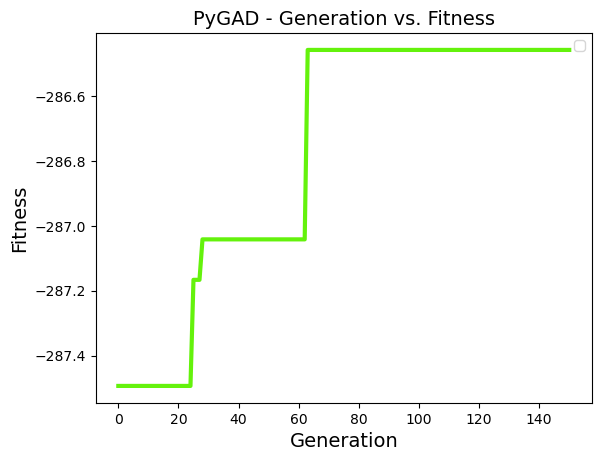

In [ ]:
ga_instance.plot_fitness()
plt.show()


--- Resultados de la Optimización ---
Frecuencias iniciales: [0.5, 0.4, 0.5, 0.45]
Frecuencias óptimas: [0.83267643 0.0217743  0.77891354 0.55740541]
Caudal inicial: 183.00
Caudal óptimo: 220.54 (Objetivo: 200)
Consumo inicial: 298.56 kW
Consumo óptimo: 286.46 kW
Reducción de consumo: 4.05%


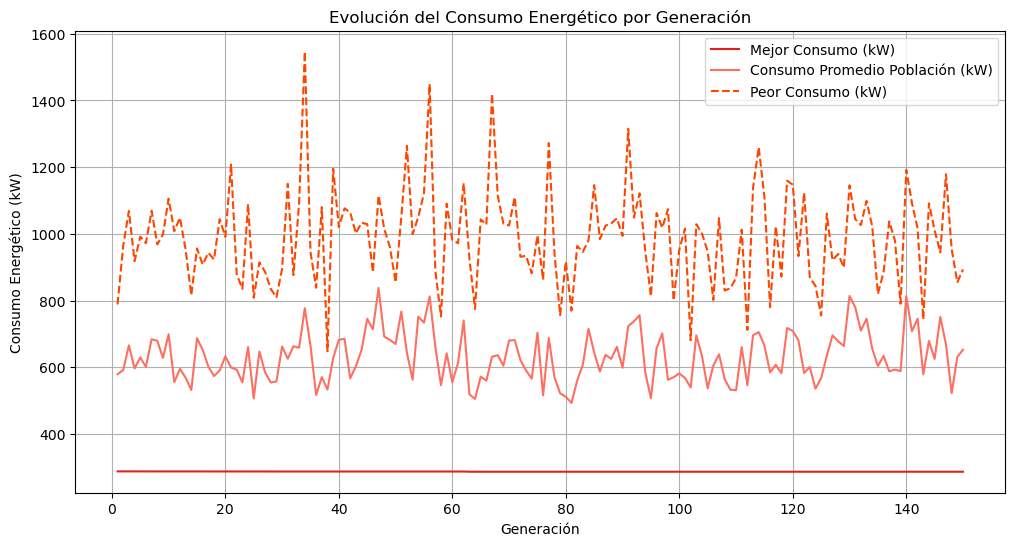

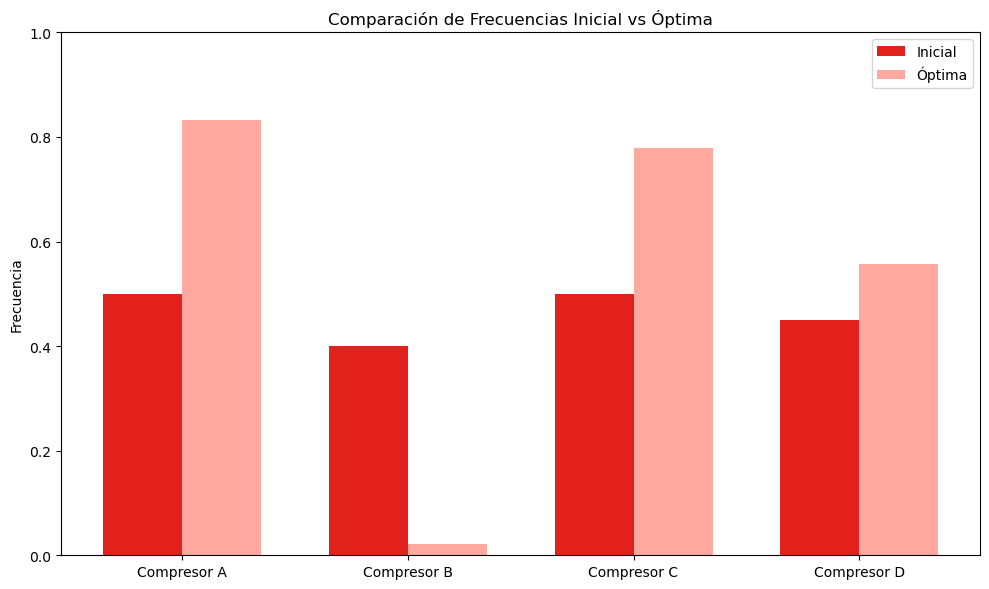

In [77]:
# Get the best solution
best_solution, best_fitness, _ = ga_instance.best_solution()
best_consumo = -best_fitness  # Convert to positive value

# Calculate flow of the best solution
best_caudal = best_solution[0]*100 + best_solution[1]*90 + best_solution[2]*95 + best_solution[3]*110

import matplotlib.pyplot as plt
import numpy as np

# Paleta de colores para los compresores
colors = ['#e2211c', '#FF6F61', '#FF4500', '#8B0000']  # He corregido el último para que sea hexadecimal válido (#8B000 es inválido, debe ser #8B0000)

def plot_optimization_results(ga_instance, inicial_frecuencia, best_solution, presion, temperatura):
    history = ga_instance.history
    generations = [x['generation'] for x in history]
    best_fitness = [x['best_fitness'] for x in history]
    avg_fitness = [x['avg_fitness'] for x in history]
    worst_fitness = [x['worst_fitness'] for x in history]

    # 1. Evolución del fitness
    plt.figure(figsize=(12, 6))
    plt.plot(generations, best_fitness, label='Mejor Consumo (kW)', color = colors[0])
    plt.plot(generations, avg_fitness, label='Consumo Promedio Población (kW)', color = colors[1])
    plt.plot(generations, worst_fitness, label='Peor Consumo (kW)', linestyle='--', color = colors[2])
    plt.xlabel('Generación')
    plt.ylabel('Consumo Energético (kW)')
    plt.title('Evolución del Consumo Energético por Generación')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. Frecuencias Inicial vs Óptima con colores personalizados
    labels = ['Compresor A', 'Compresor B', 'Compresor C', 'Compresor D']
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, inicial_frecuencia, width, label='Inicial', color='#e2211c')
    rects2 = ax.bar(x + width/2, best_solution, width, label='Óptima', color='#FF6F61', alpha=0.6)

    ax.set_ylabel('Frecuencia')
    ax.set_title('Comparación de Frecuencias Inicial vs Óptima')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.set_ylim(0, 1)

    fig.tight_layout()
    plt.show()


# El resto de tu código para mostrar resultados se mantiene igual



# Display results
print("\n--- Resultados de la Optimización ---")
print(f"Frecuencias iniciales: {inicial_frecuencia}")
print(f"Frecuencias óptimas: {best_solution}")
print(f"Caudal inicial: {inicial_frecuencia[0]*100 + inicial_frecuencia[1]*90 + inicial_frecuencia[2]*95 + inicial_frecuencia[3]*110:.2f}")
print(f"Caudal óptimo: {best_caudal:.2f} (Objetivo: {caudal_minimo})")
# The initial consumption should be calculated using the initial frequencies and the fitness function logic
# For the initial consumption, we can calculate it using the fitness function directly
initial_solution_fitness = fitness_function(ga_instance, inicial_frecuencia, 0)
initial_consumo = -initial_solution_fitness
print(f"Consumo inicial: {initial_consumo:.2f} kW")
print(f"Consumo óptimo: {best_consumo:.2f} kW")
print(f"Reducción de consumo: {((initial_consumo - best_consumo) / initial_consumo * 100):.2f}%")

# Generate graphs
plot_optimization_results(ga_instance, inicial_frecuencia, best_solution, presion, temperatura)